# Causal Inference

## MET 2010

## NTNU Business School

## Johannes Mauritzen

### Learning Goals

- Get a general overview of the challenges of giving causal interpretation to regression results of observational data

- Get an overview of several techniques that can be used to try give causal interpretation to regression models of observational data




### Literature
- ROS Ch. 20-21 (OK to skim through)


### Introduction and the fundamental problem of causal inference

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=13e2c3df-7821-4d09-b10a-af4300cea300&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

The field of causal inference is large and growing. This lab aims to give a small taste of the field and the problems that it is trying to address. 

At the root of all estimation of causal inference is the issue sometimes known as the **fundamental problem of causal inference**. This is the idea that to truly be able to estimate a causal effect, you need to have information on an inherently unobservable **counterfactual**. So if we want to estimate the effect of education on future earnings (a popular topic in labor economics), we would ideally want to compare a situation where the same individual both receives an education and does not receive an education. This, of course, is impossible. 

But when we try to instead substitute a comparison of people who have an education with those that don't, all sorts of problems pop up. People who take higher education are likely to be different, in both observable and unobservable ways compared to people who don't take an education. Some economists have even gone as far as to say that a university education is really only an elaborate signalling mechanism. Going to a prestigious university signals to future employers that you are a smart, hard-working person. This, it is argued, is what really drives the income difference between university graduates and those without a degree in the labor market.

The gold standard of causality modelling is **randomized controlled trials**, where subjects are randomly assigned to either a treatment or control group. Such randomized control experiments have become more common in economics and business (see for example the noble-prize winning work of Esther Duflo and Abhijit Banerjee where they use randomized field experiments to gain insights into developmental economics. The authors have written a popular scientific book on their work: Poor Economics). 

Ch. 18 and 19 in ROS discuss techniques for analysing data that comes from randomized control trials. If you are interested, you can skim through these chapters. But for the most part we will focus on techniques for trying to establish causal relationships in observational data. Chapters 20 and 21 in ROS cover several such techniques. We will not try to cover all these in this lab. Rather we will go through one longer example that demonstrates some principle ideas. You are encouraged to skim through chapter 20 and 21 and make use of one or several of the techniques and ideas in your course project. 
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns



In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.facecolor'] ="white"
plt.rcParams['grid.color'] ="grey"
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["axes.labelsize"]= 14
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="white"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']




## The effect of auditing on dividends among small, private firms in Norway

Auditors have important informational and quality control roles in modern economies. They ensure that the information companies release through their annual financial accounts is reliable and accurate. This in turn gives confidence to third-parties who have a stake in a given company: Banks and other lenders, suppliers, investors and even consumers. 

But auditing also comes with substantial costs - especially for small firms. Up until 2011, all registered Norwegian firms - no matter size - needed to obtain an audit of their yearly financial accounts. But from 2011 a new policy was put in place where firms with operating income of under 5 million kroners **and** total assets of under 20 million kroners did not need to obtain an audit. 

In this lab we want to try to answer the question of what the effect of auditing is on the dividend pay-out of small private firms. The dividend is the main way that owners of firms extract capital from their firms. We might hypothesize that without the disciplining effect of an auditor, firms might be tempted to extract more from their firms. 

We start by loading in our data set: 

In [3]:
aq_long = pd.read_csv("https://jmaurit.github.io/anv_statistikk/data/aq_long.csv")

This data has already been partially filtered and cleaned. Very small firms and specialty firms that are under special auditing rules-like law firms-have been removed. 

We do some extra cleaning of our data - revising our year variable to just show the year

In [4]:
aq_long.year

0        2005-01-01
1        2006-01-01
2        2007-01-01
3        2008-01-01
4        2009-01-01
            ...    
31521    2011-01-01
31522    2012-01-01
31523    2013-01-01
31524    2014-01-01
31525    2015-01-01
Name: year, Length: 31526, dtype: object

In [6]:
aq_long.loc[:,"year"] = pd.to_datetime(aq_long.year)
aq_long["year"] = aq_long.year.dt.year




We already have an indicator variable for whether a firm received an auditor or not: *no_auditor*, which is equal to 1 if a firm did not obtain an audit. Thus the **treatment** here is the absence of an audit. 

We also have a variable called *vol_auditor*, which indicates that a firm (after 2011) was below the thresholds for being able to forgo an auditor (an audit becomes voluntary). 

Below we will both create a label-variable for whether a firm got audited, and we will create an indicator variable *choseAudit* which indicates that a firm did not need to obtain an audit, but did anyways:  

In [6]:
aq_long["no_auditor_lab"] = "Auditor"
aq_long.loc[aq_long.no_auditor==1, "no_auditor_lab"]="No auditor"
aq_long["choseAudit"] = aq_long.vol_auditor - aq_long.no_auditor


aq_long.head()

,index,cid,nkode_15,year,driftsinntekter,AM,EK,Varelager,OM,KF,...,antall_ansatte,leverage,endring_Eiendeler,risk_roa,cash_flow,cash_flow_mu,cash_flow_sd,Arb.sats,no_auditor_lab,choseAudit
0,14157,810130822,46.739,2005,5859000,541000,334000,1440000,1946000,466000,...,5,1.307197,NaN,0.039061,72000,241818.181818,144472.708967,0.106,Auditor,0
1,14158,810130822,46.739,2006,6254000,527000,469000,1355000,1924000,499000,...,5,1.337005,-36000.0,0.039061,175000,241818.181818,144472.708967,0.106,Auditor,0
2,14159,810130822,46.739,2007,6876000,2830000,697000,1362000,1785000,328000,...,5,1.257638,2164000.0,0.039061,360000,241818.181818,144472.708967,0.106,Auditor,0
3,14160,810130822,46.739,2008,6461000,2933000,705000,1158000,1320000,117000,...,5,0.691747,-362000.0,0.039061,168000,241818.181818,144472.708967,0.106,Auditor,0
4,14161,810130822,46.739,2009,6608000,2911000,617000,953000,1077000,84000,...,5,0.668004,-265000.0,0.039061,108000,241818.181818,144472.708967,0.106,Auditor,0


Now we will create a graphic showing the incidence of firms that have forgone an audit after 2010

Text(0.08, 0.5, 'Operating income (t-1), million NOK')

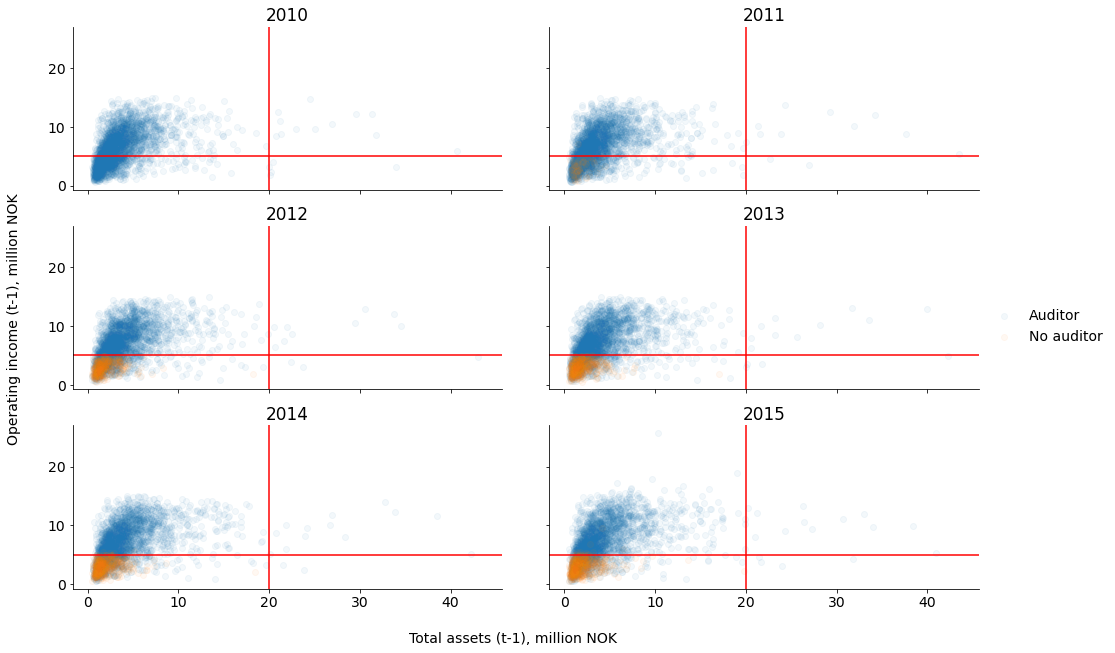

In [7]:
year_lab = ["2010", "2011", "2012", "2013", "2014", "2015"]

aq_long["Eiendeler_lagM"] = aq_long.Eiendeler_lag/1000000
aq_long["driftsinntekter_lagM"] = aq_long.driftsinntekter_lag/1000000

aud_scatter = sns.FacetGrid(aq_long[(aq_long.year > 2009)],col="year", hue="no_auditor_lab" , col_wrap=2, legend_out=True)
aud_scatter = (aud_scatter.map(plt.scatter, "Eiendeler_lagM", "driftsinntekter_lagM", alpha=.05)
               .set_axis_labels("", "")) 
#aud_scatter.set_titles = "year_lab"
aud_scatter.fig.set_size_inches([15,9])
aud_scatter.add_legend()
aud_scatter._legend.set_title("")
for ax in aud_scatter.axes:
    ax.axvline(20, color="red")
    ax.axhline(5, color="red")
    
for i, ax in enumerate(aud_scatter.axes):
    ax.set_title(year_lab[i])

aud_scatter.fig.text(0.5, 0, 'Total assets (t-1), million NOK', ha='center')
aud_scatter.fig.text(0.08, 0.5, 'Operating income (t-1), million NOK', va='center', rotation='vertical')



The red lines represent the threshold variables

One thing we can see from the data is that operating income seems to be the constraining threshold for being eligible to forgo an audit. That is, there are very few firms that are under the operating income threshold but over the total assets threshold. We will therefor focus on this threshold in our analysis.

### Rescaling series

We'll follow the general advice from ROS, and transform our variables in our analysis to be standardized - we subtract the mean and divide by the standard deviation. 

Here we'll create a function to do the standardardization

In [8]:
#Rescaling
def rescale_series(ser):
    ser_rs = (ser - ser.mean())/ser.std()
    return(ser_rs)

We indicate which variables we wish to transform:

In [9]:
#Transform all continuous variables
transformed_vars = ['AM', 'EK',
       'Varelager', 'OM', 'KF', 'LG', 'KG', 'Varekost', 'Netincome',
       'Avskrivninger', 'ordres', 'rentekostnad', 'Driftsresultat',
       'Varigedm', 'age', 'cash', 'Finam', 'konsernbidrag', 'utbytte',
       'rentekost_foretak', 'annen_finanskost','Eiendeler', 'ROA', 'driftsinntekter_lag',
       'Eiendeler_lag', 'antall_ansatte',
       'leverage', 'endring_Eiendeler', 'risk_roa', 'cash_flow', "cash_flow_mu", "cash_flow_sd"]



We'll limit our data from 2011 to 2015, after the implimentation of the policy

In [10]:
#limit to 2011 to 2015
aq_rs = aq_long.loc[aq_long.year>2010,:].copy()


We will save some values for standard deviations and means for use later

In [11]:
#standard deviations and means to save
operIncome_std = aq_rs.driftsinntekter.std() #operating income std
dividend_std = aq_rs.utbytte.std() #operating
dividend_mu = aq_rs.utbytte.mean()


We will rescale our continuous variables

In [12]:
#rescale variables
aq_rs.loc[:, transformed_vars]=aq_rs.loc[:,transformed_vars].apply(rescale_series)


We will make one exception to our rescaling. For our operating income variable (*driftsinntekter*), we will subtract 5 million - the threshold value for being able to forgo an auditor. Thus a company with a rescaled value of 0 will be right on the threshold value

In [13]:
#rescale driftsinntekter:
aq_rs.loc[:,"driftsinntekter"] = (aq_rs.driftsinntekter - 5000000)/operIncome_std


We can look at a histogram of the distribution of the rescaled operating income variable

<AxesSubplot:>

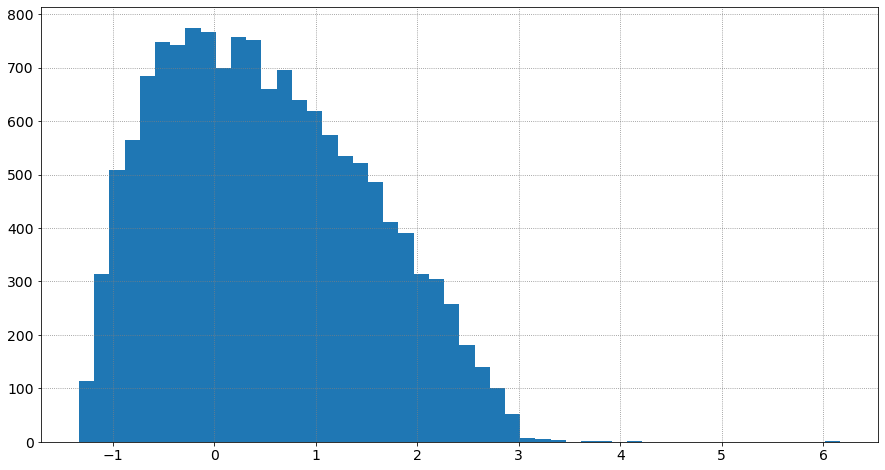

In [17]:
aq_rs.driftsinntekter.hist(bins=50)

### Naive model

Now let's run a simple, naive regression model, where we will regress the dividend on the *no_auditor* indicator variables and some year indicator variables - sometimes called year **fixed effects**.

In [19]:
rd_mod1 = smf.ols("utbytte~no_auditor + C(year)", 
                       data=aq_rs).fit()
rd_mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     25.68
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           6.76e-26
Time:                        08:32:25   Log-Likelihood:                -20269.
No. Observations:               14330   AIC:                         4.055e+04
Df Residuals:                   14324   BIC:                         4.060e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0199      0.019     -1.071      0.284      -0.056       0.017
C(year)[T.2012]     0.0587      0.026      2.218      0.027       0.007       0.110
C(year)[T.2013]     0.0742      0.027      2.799      0.005       0.022       0.126
C(year)[T.2014]     0.0740      0.027      2.787      0.005       0.022       0.126
C(year)[T.2015]     0.0814      0.027      3.063      0.002       0.029       0.134
no_auditor         -0.2745      0.025    -11.204      0.000      -0.323      -0.226
==============================================================================
Omnibus:                    17008.853   Durbin-Watson:                   1.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3192772.769
Skew:                           6.160   Prob(JB):                         0.00
Kurtosis:                      75.080   Cond. No.                         5.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Lurking variables and omitted variable bias

<iframe src="https://ntnu.cloud.panopto.eu/Panopto/Pages/Embed.aspx?id=f1ab0fae-4efa-4159-8d62-af4300cea305&autoplay=false&offerviewer=true&showtitle=true&showbrand=true&captions=false&interactivity=all" height="405" width="720" style="border: 1px solid #464646;" allowfullscreen allow="autoplay"></iframe>

The coefficient on the *no_auditor* variable is estimated to be negative. We could interpret it to mean that not having an auditor will *reduce* the dividend by .27 standard deviations, which is estimated rather precisely with a confidence interval roughly between -.22 and -.32.

But it would be a mistake to interpret this causally. First and foremost, we likely have a *lurking* or *omitted* variable bias in the estimation (ROS p. 385). That is, the coefficient on *no_auditor* is picking up the effect of another variable. 

In this case, we might expect that this is the operating income variable, which both is the *forcing* variable that decides eligibility for forgoing an audit, and which is correlated with the dividend - a higher operating income can be expected to be correlated with higher dividend. 

So now, let's include a second regression where we control for operating income, as well as other **confounding variables** (ROS p. 386) that may be correlated with both the indicator variable *no_auditor* and the left-hand side variable, dividend ("utbytte"). This includes number of employees ("antall_ansatte"), and total assets ("Eiendeler"). 

We might also be concerned that the choice to forgo auditing may be correlated with a firm's riskiness, and that might be skewing the results. So we include measures of firm risk (Return on Assets) as well as an indicator of firm leverage: 

In [24]:
regForm = "utbytte~no_auditor+C(year)+driftsinntekter+driftsinntekter**2+antall_ansatte+Eiendeler+risk_roa+leverage"
rs_mod2 = smf.ols(regForm, data=aq_rs).fit()
rs_mod2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     122.8
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          6.83e-247
Time:                        09:00:52   Log-Likelihood:                -19743.
No. Observations:               14330   AIC:                         3.951e+04
Df Residuals:                   14319   BIC:                         3.959e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1317      0.019     -7.040      0.000      -0.168      -0.095
C(year)[T.2012]     0.0135      0.026      0.529      0.597      -0.037       0.064
C(year)[T.2013]     0.0191      0.026      0.745      0.456      -0.031       0.069
C(year)[T.2014]     0.0022      0.026      0.085      0.933      -0.048       0.053
C(year)[T.2015]    -0.0028      0.026     -0.109      0.913      -0.053       0.048
no_auditor          0.0722      0.027      2.720      0.007       0.020       0.124
driftsinntekter     0.2260      0.011     21.469      0.000       0.205       0.247
antall_ansatte     -0.0882      0.009    -10.075      0.000      -0.105      -0.071
Eiendeler           0.1287      0.010     13.305      0.000       0.110       0.148
risk_roa           -0.0232      0.009     -2.670      0.008      -0.040      -0.006
leverage            0.0792      0.009      8.739      0.000       0.061       0.097
==============================================================================
Omnibus:                    16751.549   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3323873.499
Skew:                           5.959   Prob(JB):                         0.00
Kurtosis:                      76.653   Cond. No.                         7.97
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have included measures of firm size and riskiness, the coefficient on *no_auditor* has flipped to be positive, with a point estimate of .0722, with a rough 95% confidence interval of between .02 and .13.

### Post-treatment variables

One variable we have not included, but which we might be expected to both be correlated with the *no_auditor* indicator and dividend is cash flow. But, following ROS (p. 374-379) we should be careful about included **post treatment** and **mediating** variables. 

In the context of our estimation problem, a firm's cash flow for a certain year is jointly determined with the dividend. That is, if we imagine that auditing can have an effect on dividend, it can imagined to also have an effect on cash flow, and that the decision on the dividend can also affect the cash flow information. Controlling for cash flow will then in effect control for some of the variation we are interested in estimating. 

Instead, in our data, we have created more aggregated measures of firm cash flow based on all the years of data - we have created mean cash flow: *cash_flow_mu* across years, and a standard deviation of cash flow, *cash_flow_sd* across years, which gives an indication of the volatility of a firm's cash flow. 

In [26]:
regForm = "utbytte~no_auditor+C(year)+driftsinntekter+driftsinntekter**2+ antall_ansatte+Eiendeler+risk_roa+leverage + cash_flow_mu + cash_flow_sd"
rs_mod3 = smf.ols(regForm, data=aq_rs).fit()
rs_mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     541.1
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:14:39   Log-Likelihood:                -17653.
No. Observations:               14330   AIC:                         3.533e+04
Df Residuals:                   14317   BIC:                         3.543e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.0578      0.016     -3.569      0.000      -0.090      -0.026
C(year)[T.2012]     0.0236      0.022      1.068      0.286      -0.020       0.067
C(year)[T.2013]     0.0311      0.022      1.406      0.160      -0.012       0.075
C(year)[T.2014]     0.0248      0.022      1.117      0.264      -0.019       0.068
C(year)[T.2015]     0.0270      0.022      1.212      0.225      -0.017       0.071
no_auditor          0.0517      0.023      2.252      0.024       0.007       0.097
driftsinntekter     0.0576      0.010      6.055      0.000       0.039       0.076
antall_ansatte      0.0172      0.008      2.228      0.026       0.002       0.032
Eiendeler           0.0017      0.009      0.183      0.855      -0.016       0.019
risk_roa           -0.0461      0.009     -5.278      0.000      -0.063      -0.029
leverage            0.1023      0.008     12.966      0.000       0.087       0.118
cash_flow_mu        0.5182      0.008     67.821      0.000       0.503       0.533
cash_flow_sd        0.0606      0.009      6.727      0.000       0.043       0.078
==============================================================================
Omnibus:                    16501.229   Durbin-Watson:                   1.357
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5041003.611
Skew:                           5.612   Prob(JB):                         0.00
Kurtosis:                      94.196   Cond. No.                         8.46
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sub-classification

We should probably still be in doubt about whether we can consider our *no_auditor* indicator as **ignorable** (ROS 388), that is that the sorting into audited and non-audited groups is close to random, conditional on the controlling variables in the regression. 

One way we could potentially improve our estimation is by excluding the firms that could have forgone an auditor, but still chose to obtain one. Excluding these firms is a form of **sub-classification** (ROS 397), where now we are comparing groups under the threshold that have forgone an auditor, with those above, that were not eligible. 

We could divide the groups as in the figure below. Ideally, we would like to compare those firms below the threshold, who would forgo an auditor if possible (and thus do) with firms above the threshold who can not forgo an auditor, but would if they could. Unfortunately, we only observe which firms would forgo an auditor for those below the threshold: 

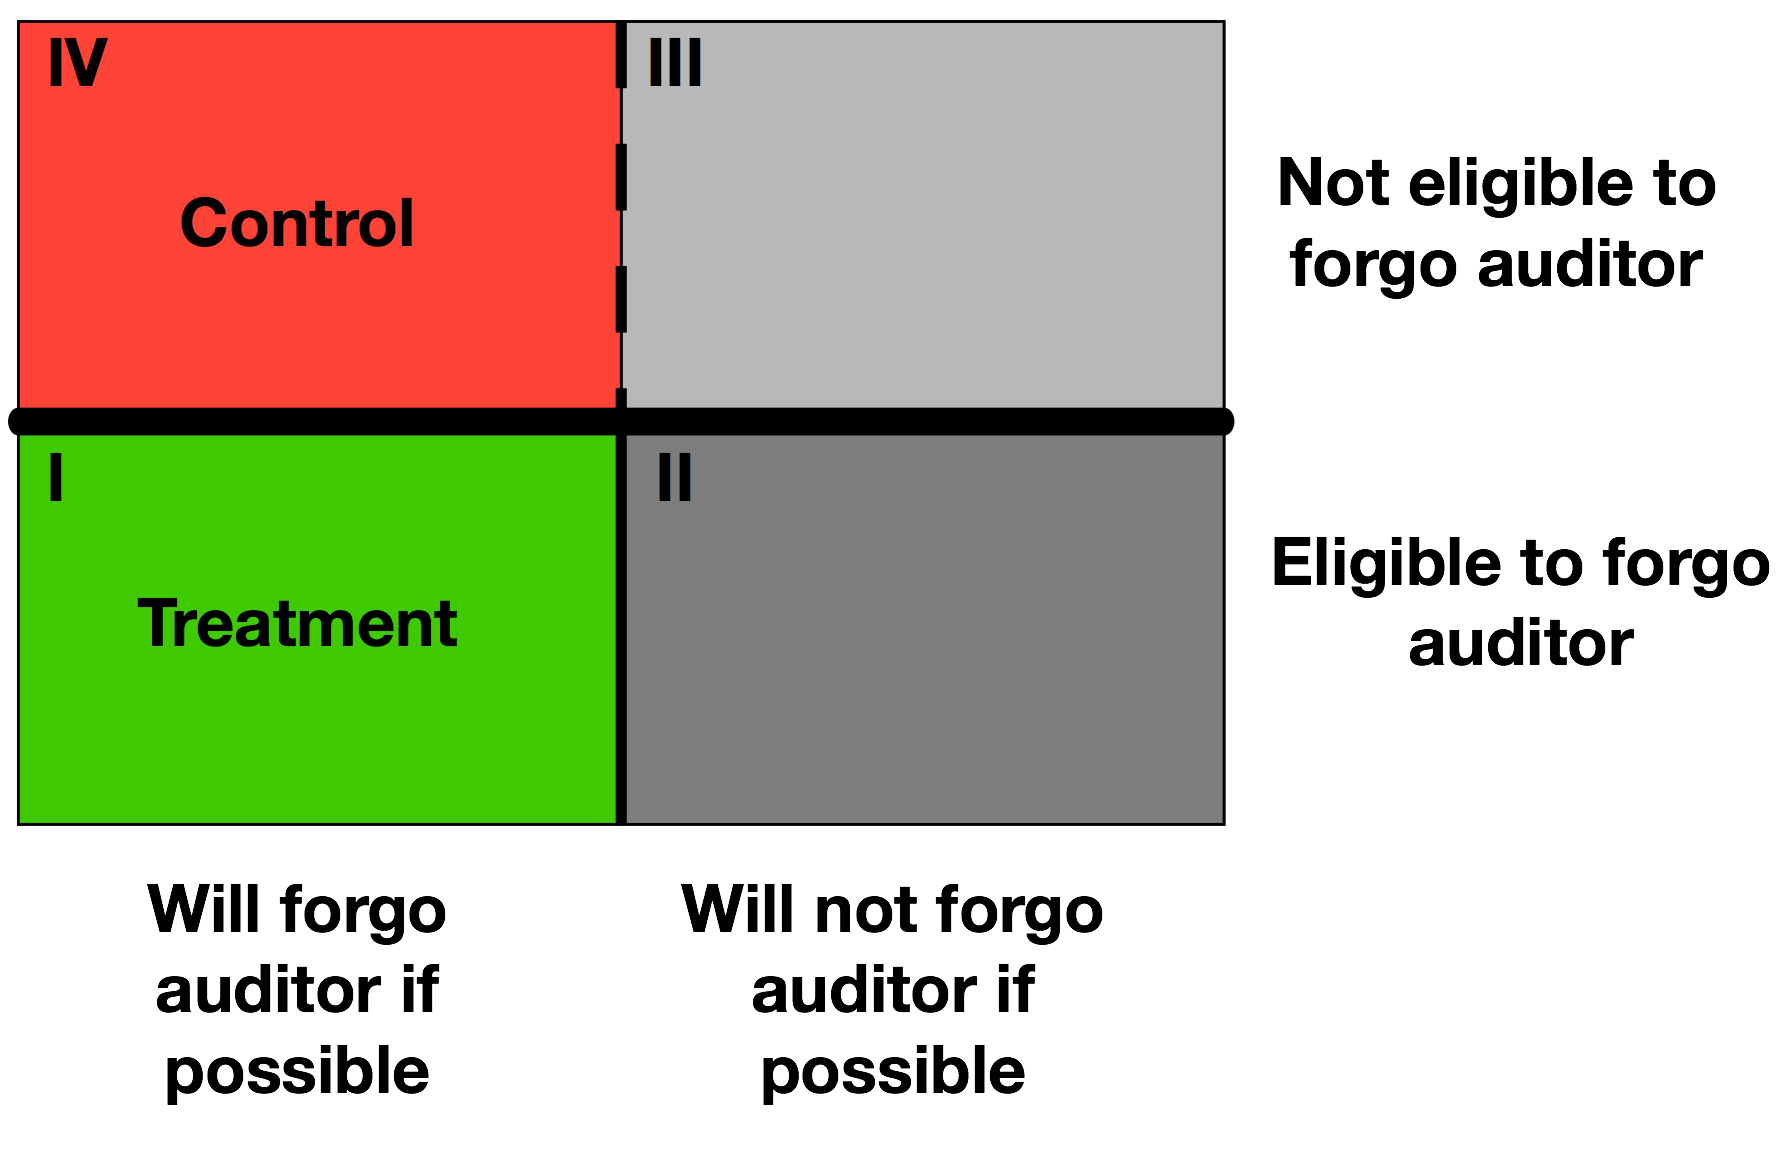

In [27]:
rs_mod4 = smf.ols("utbytte~no_auditor + C(year) + driftsinntekter + driftsinntekter**2 + antall_ansatte + Eiendeler + leverage + risk_roa  + cash_flow_mu + cash_flow_sd", 
                       data=aq_rs.loc[aq_rs.choseAudit==0, ]).fit()

In [29]:
rs_mod4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     449.5
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:50:22   Log-Likelihood:                -14476.
No. Observations:               11110   AIC:                         2.898e+04
Df Residuals:                   11097   BIC:                         2.907e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1456      0.024     -6.074      0.000      -0.193      -0.099
C(year)[T.2012]     0.0378      0.028      1.346      0.178      -0.017       0.093
C(year)[T.2013]     0.0544      0.028      1.950      0.051      -0.000       0.109
C(year)[T.2014]     0.0509      0.028      1.821      0.069      -0.004       0.106
C(year)[T.2015]     0.0519      0.028      1.860      0.063      -0.003       0.107
no_auditor          0.1537      0.030      5.077      0.000       0.094       0.213
driftsinntekter     0.0986      0.013      7.348      0.000       0.072       0.125
antall_ansatte      0.0225      0.009      2.579      0.010       0.005       0.040
Eiendeler          -0.0145      0.011     -1.330      0.183      -0.036       0.007
leverage            0.1403      0.011     13.257      0.000       0.120       0.161
risk_roa           -0.0830      0.013     -6.207      0.000      -0.109      -0.057
cash_flow_mu        0.5371      0.009     62.619      0.000       0.520       0.554
cash_flow_sd        0.0792      0.011      7.236      0.000       0.058       0.101
==============================================================================
Omnibus:                    12249.409   Durbin-Watson:                   1.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3188696.954
Skew:                           5.217   Prob(JB):                         0.00
Kurtosis:                      85.337   Cond. No.                         9.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Once we exclude the firms that voluntarily obtained an audit, the coefficient on *no_auditor* increases to .15, with a rough confidence interval of .09 to .21

### Industry fixed-effects

A last step, in terms of trying to improve the comparisons in the model is to add indicator variables for the industry, as represented by the *nkode* variable,so called **industry fixed effects**. In effect, we can then interpret the *no_auditor* variable as a comparison between firms in the same industry who do, and do not obtain an audit. 

In [33]:
rs_mod5 = smf.ols("utbytte~ C(nkode_agg) + no_auditor + C(year) + driftsinntekter + driftsinntekter**2 + antall_ansatte + Eiendeler + risk_roa + leverage  + cash_flow_mu + cash_flow_sd", 
                       data=aq_rs.loc[aq_rs.choseAudit==0,:]).fit()
rs_mod5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     83.15
Date:                Tue, 01 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:43:54   Log-Likelihood:                -14379.
No. Observations:               11110   AIC:                         2.890e+04
Df Residuals:                   11041   BIC:                         2.940e+04
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.3385      0.109     -3.108      0.002      -0.552      -0.125
C(nkode_agg)[T.2]      0.4998      0.247      2.020      0.043       0.015       0.985
C(nkode_agg)[T.8]      0.1144      0.149      0.766      0.444      -0.178       0.407
C(nkode_agg)[T.10]     0.2489      0.130      1.908      0.056      -0.007       0.505
C(nkode_agg)[T.11]     0.0392      0.456      0.086      0.931      -0.854       0.933
C(nkode_agg)[T.13]     0.1375      0.142      0.966      0.334      -0.141       0.416
C(nkode_agg)[T.14]     0.3256      0.300      1.086      0.278      -0.262       0.914
C(nkode_agg)[T.15]     0.1142      0.410      0.278      0.781      -0.690       0.919
C(nkode_agg)[T.16]     0.1160      0.124      0.936      0.349      -0.127       0.359
C(nkode_agg)[T.17]     0.3187      0.260      1.224      0.221      -0.191       0.829
C(nkode_agg)[T.18]     0.2752      0.121      2.279      0.023       0.038       0.512
C(nkode_agg)[T.20]     0.1419      0.196      0.723      0.470      -0.243       0.526
C(nkode_agg)[T.22]     0.2399      0.138      1.735      0.083      -0.031       0.511
C(nkode_agg)[T.23]     0.4545      0.129      3.515      0.000       0.201       0.708
C(nkode_agg)[T.24]     0.2799      0.277      1.010      0.312      -0.263       0.823
C(nkode_agg)[T.25]     0.2908      0.118      2.475      0.013       0.060       0.521
C(nkode_agg)[T.26]     0.2191      0.202      1.087      0.277      -0.176       0.614
C(nkode_agg)[T.27]     0.1544      0.171      0.901      0.367      -0.181       0.490
C(nkode_agg)[T.28]     0.3713      0.127      2.918      0.004       0.122       0.621
C(nkode_agg)[T.29]     0.0920      0.300      0.307      0.759      -0.496       0.680
C(nkode_agg)[T.30]     0.0492      0.252      0.195      0.846      -0.446       0.544
C(nkode_agg)[T.31]     0.3125      0.147      2.132      0.033       0.025       0.600
C(nkode_agg)[T.32]     0.3042      0.136      2.234      0.026       0.037       0.571
C(nkode_agg)[T.33]     0.2974      0.126      2.366      0.018       0.051       0.544
C(nkode_agg)[T.41]     0.1229      0.128      0.964      0.335      -0.127       0.373
C(nkode_agg)[T.42]     0.3049      0.179      1.704      0.088      -0.046       0.656
C(nkode_agg)[T.43]     0.2483      0.109      2.278      0.023       0.035       0.462
C(nkode_agg)[T.45]     0.1918      0.111      1.732      0.083      -0.025       0.409
C(nkode_agg)[T.46]     0.0916      0.109      0.840      0.401      -0.122       0.306
C(nkode_agg)[T.47]     0.1320      0.108      1.222      0.222      -0.080       0.344
C(nkode_agg)[T.49]     0.3229      0.143      2.265      0.024       0.043       0.602
C(nkode_agg)[T.50]    -0.8718      0.304     -2.866      0.004      -1.468      -0.276
C(nkode_agg)[T.52]    -0.0817      0.2

This also has the effect of increasing the *no_auditor* indicator

### Regression Discontinuity. 

In this study, since we have a sharp cut-off for eligibility that is at a certain level arbitrary, we can use a **regression discontinuity** design. This is the idea that whether a firm is just above or below the threshold, can be considered essentially random, and thus comparing firms close to the threshold, we can to a higher degree consider the sorting of firms into audited and non-audited to be ignorable. 

We have the basic set-up already in place, now we just limit our data to firms within +/- 1 million in operating income

In [35]:
#narrow results
min_di = (4e6-5e6)/operIncome_std
max_di = (6e6-5e6)/operIncome_std
print(min_di, max_di)

aq_narrow = aq_rs.loc[((aq_rs.choseAudit==0) & (aq_rs.driftsinntekter>min_di) & (aq_rs.driftsinntekter<max_di)) ,:]

-0.2970846713856964 0.2970846713856964


We then run a regression with the same control variables as before. We could, in theory have a simpler specification, if we are very confident that our treatment assignment is now truly random, but adding control variables can also improve the efficiency of our results - that is reduce the amount of variance. 

In [37]:
rs_mod6 = smf.ols("utbytte~no_auditor + C(year) + driftsinntekter + driftsinntekter**2 + antall_ansatte + Eiendeler + risk_roa + leverage + cash_flow_mu + cash_flow_sd + C(nkode_agg)", 
                       data=aq_narrow).fit()
rs_mod6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     8.309
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           8.74e-59
Time:                        10:51:12   Log-Likelihood:                -1765.4
No. Observations:                1837   AIC:                             3649.
Df Residuals:                    1778   BIC:                             3974.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4391      0.325     -1.352      0.177      -1.076       0.198
C(year)[T.2012]    -2.423e-05      0.050     -0.000      1.000      -0.098       0.098
C(year)[T.2013]        0.0043      0.049      0.088      0.930      -0.092       0.101
C(year)[T.2014]       -0.0378      0.050     -0.750      0.453      -0.137       0.061
C(year)[T.2015]        0.0612      0.050      1.211      0.226      -0.038       0.160
C(nkode_agg)[T.2]     -0.0836      0.732     -0.114      0.909      -1.519       1.351
C(nkode_agg)[T.8]      0.1775      0.435      0.408      0.683      -0.675       1.030
C(nkode_agg)[T.10]     0.0700      0.383      0.183      0.855      -0.682       0.822
C(nkode_agg)[T.13]     0.3290      0.350      0.941      0.347      -0.357       1.015
C(nkode_agg)[T.14]     0.2259      0.560      0.404      0.687      -0.872       1.324
C(nkode_agg)[T.15]     0.2159      0.433      0.499      0.618      -0.633       1.065
C(nkode_agg)[T.16]     0.2391      0.344      0.694      0.488      -0.436       0.914
C(nkode_agg)[T.18]     0.4581      0.336      1.363      0.173      -0.201       1.117
C(nkode_agg)[T.20]     0.0419      0.721      0.058      0.954      -1.372       1.456
C(nkode_agg)[T.22]     0.4945      0.376      1.313      0.189      -0.244       1.233
C(nkode_agg)[T.23]     0.3601      0.364      0.990      0.322      -0.353       1.073
C(nkode_agg)[T.24]     1.0495      0.560      1.874      0.061      -0.049       2.148
C(nkode_agg)[T.25]     0.5668      0.332      1.705      0.088      -0.085       1.219
C(nkode_agg)[T.26]     0.2231      0.417      0.535      0.593      -0.595       1.042
C(nkode_agg)[T.27]     0.2203      0.416      0.529      0.597      -0.596       1.037
C(nkode_agg)[T.28]     0.4150      0.349      1.190      0.234      -0.269       1.099
C(nkode_agg)[T.30]     0.2191      0.492      0.445      0.656      -0.746       1.184
C(nkode_agg)[T.31]     0.3741      0.358      1.044      0.297      -0.329       1.077
C(nkode_agg)[T.32]     0.4098      0.351      1.166      0.244      -0.280       1.099
C(nkode_agg)[T.33]     0.2554      0.345      0.739      0.460      -0.422       0.933
C(nkode_agg)[T.41]     0.3289      0.348      0.945      0.345      -0.353       1.011
C(nkode_agg)[T.42]     0.4427      0.397      1.116      0.264      -0.335       1.220
C(nkode_agg)[T.43]     0.3270      0.325      1.007      0.314      -0.310       0.964
C(nkode_agg)[T.45]     0.3199      0.326      0.980      0.327      -0.320       0.960
C(nkode_agg)[T.46]     0.2897      0.325      0.891      0.373      -0.348       0.928
C(nkode_agg)[T.47]     0.2991      0.324      0.923      0.356      -0.336       0.935
C(nkode_agg)[T.49]     0.4610      0.364      1.266      0.206      -0.253       1.175
C(nkode_agg)[T.52]     0.3147      0.4

This did not end up having a large effect on the estimation of our *no_auditor* coefficient, other than increasing the standard error, which would be expected when reducing the number of observations. It seems our control variables have done a pretty good job of controlling for the variation in the firms other than their auditing status. 

### Illustration of regression discontinuity

We can illustrate our regression discontinuity with simulated uncertainty. First, we copy our function for simulating regression model uncertainty from lab 9: 

In [38]:
def regSim(regMod): 
    #extract values from regression model
    nmk = regMod.df_resid #n-k
    sigma_hat = np.sqrt(regMod.mse_resid)
    bs_vcov = regMod.cov_params(scale=1)
    bs = regMod.params
    
    #create simulated values
    sigma_sim = sigma_hat*np.sqrt((nmk/np.random.chisquare(nmk,1)))
    V_sim = np.array(bs_vcov) * sigma_sim**2
    bs_sim = np.random.multivariate_normal(bs, V_sim, 1)
    
    return([bs_sim.flatten(), sigma_sim])



We will first run a model, not including industry fixed effects, for simplicity. 

In [39]:
rs_mod_fig = smf.ols("utbytte~no_auditor + C(year) + driftsinntekter + driftsinntekter**2 + antall_ansatte + Eiendeler + risk_roa + leverage + cash_flow_mu + cash_flow_sd", 
                       data=aq_narrow).fit()

In [51]:
rs_mod_fig.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     34.96
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           1.27e-73
Time:                        11:08:53   Log-Likelihood:                -1795.5
No. Observations:                1837   AIC:                             3617.
Df Residuals:                    1824   BIC:                             3689.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1000      0.038     -2.621      0.009      -0.175      -0.025
C(year)[T.2012]     0.0024      0.050      0.049      0.961      -0.095       0.100
C(year)[T.2013]    -0.0011      0.049     -0.021      0.983      -0.097       0.095
C(year)[T.2014]    -0.0408      0.050     -0.815      0.415      -0.139       0.057
C(year)[T.2015]     0.0641      0.050      1.274      0.203      -0.035       0.163
no_auditor          0.1396      0.045      3.080      0.002       0.051       0.228
driftsinntekter     0.2575      0.108      2.379      0.017       0.045       0.470
antall_ansatte     -0.0219      0.022     -0.994      0.320      -0.065       0.021
Eiendeler           0.0746      0.019      3.909      0.000       0.037       0.112
risk_roa           -0.0042      0.023     -0.181      0.856      -0.050       0.041
leverage            0.0321      0.012      2.649      0.008       0.008       0.056
cash_flow_mu        0.4086      0.022     18.357      0.000       0.365       0.452
cash_flow_sd       -0.0025      0.020     -0.125      0.901      -0.042       0.037
==============================================================================
Omnibus:                     2992.007   Durbin-Watson:                   1.828
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2992577.853
Skew:                          10.204   Prob(JB):                         0.00
Kurtosis:                     199.674   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
sim = regSim(rs_mod_fig)
sim_inter = sim[0][0]
sim_treat = sim[0][5]
sim_beta = sim[0][6]
print(sim_inter, sim_treat, sim_beta)

-0.1149942250768759 0.0907645709571931 0.1847980214329764


In [ ]:
nsim = 50

bs_sims = []
sigma_sims = []



for s in range(nsim):
    param_sim = regSim(mod1)
    bs_sims.append(param_sim[0])
    sigma_sims.append(param_sim[1])



In [45]:
rs_mod_fig.cov_params()
se = np.sqrt(np.diagonal(rs_mod_fig.cov_params()))
params = rs_mod_fig.params
ses = dict(zip(params.index, se))

#we transform these variables back into the original scale by multipling by the standard deviations we save earlier
treat = rs_mod_fig.params["no_auditor"]
treat_se =ses["no_auditor"]
inter = rs_mod_fig.params["Intercept"]
inter_se = ses["Intercept"]
di = rs_mod_fig.params["driftsinntekter"]
di_se = ses["driftsinntekter"]
print("treatment", treat, treat_se)
print("Intercept", inter, inter_se)
print("di", di, di_se)

treatment 0.13958126433061546 0.04531536307535993
Intercept -0.09995932575667374 0.03814291312126054
di 0.25750323354220367 0.10823193503332862


In [46]:
pre_x = np.linspace(-2, 0, 1000)
post_x = np.linspace(0, 2, 1000)

post_y = inter + post_x*di
pre_y = inter + pre_x*di + treat



Text(0, 0.5, 'Dividend, in StD')

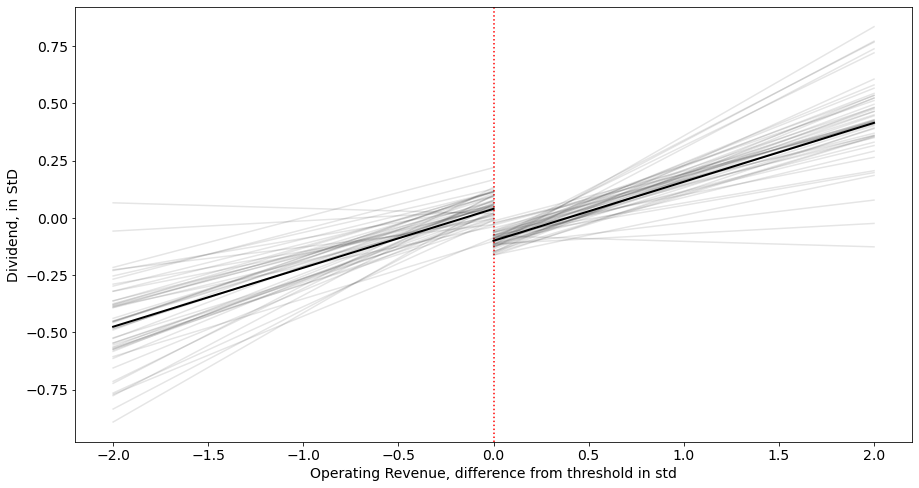

In [55]:
fig, ax = plt.subplots()
ax.plot(pre_x, pre_y, "k-", lw=2)
ax.plot(post_x, post_y, "k-", lw=2)
ax.axvline(0, color="red", linestyle=":")

#uncertainty
for i in range(50):
    sim = regSim(rs_mod_fig)
    sim_inter = sim[0][0]
    sim_treat = sim[0][5]
    sim_beta = sim[0][6]

    post_y_r = sim_inter + sim_beta*post_x
    pre_y_r = sim_inter + sim_treat + sim_beta*pre_x
    
    
    ax.plot(pre_x, pre_y_r, "k-", alpha=.1)
    ax.plot(post_x, post_y_r, "k-", alpha=.1)
#ax.set_ylim(0, 4e5)
#ax.set_xlim(4e6, 6e6)
ax.set_xlabel("Operating Revenue, difference from threshold in std")
ax.set_ylabel("Dividend, in StD")



The jump, or discontinuity at the threshold for operating revenue represents the point estimate on the *no_auditor* variable

### Matching

Ideally, to get a causal interpretation of our estimation, we should seek to have a **balance** (ROS p391-394) between our treatment and control groups. In our example, that means we want to compare roughly similar firms that both are audited and are not audited. One set of techniques we can make use of are called **matching** (p.400-. 

Matching consists of two basic steps:

- First, some form of algorithm is used to find an appropriate, balanced control group for the treatment group. 
- Run a new regression, with the treatment and new matched control group. 

We will do a relatively simple form of matching called **propensity score** matching. 


We start by creating a logistic regression model to create a prediction of what firms are likely to forgo auditing among firms below the threshold. The fitted values of this model - in the form of probabilities - are called **propensity scores**. 

The aim of this model is to give a best possible fit, so we will include multiple explanatory variables and their squares: 

In [58]:
ps_fit = smf.logit("no_auditor ~ C(year) + driftsinntekter + I(driftsinntekter**2) + antall_ansatte + antall_ansatte*driftsinntekter +  I(antall_ansatte**2) + Eiendeler + I(Eiendeler**2) + leverage + I(leverage**2) + risk_roa + I(risk_roa**2) + cash_flow_mu + I(cash_flow_mu**2) + cash_flow_sd + I(cash_flow_sd**2)", 
                       data=aq_rs.loc[aq_rs.vol_auditor==1, ]).fit()
pscores = ps_fit.predict()

Optimization terminated successfully.
         Current function value: 0.552025
         Iterations 8


Then we restrict the propensity scores to the firms who chose to get audited

In [60]:
pscores_noaudit = pscores[ps_fit.model.data.endog==1]
pscores_noaudit

array([0.46292287, 0.60140932, 0.61065614, ..., 0.56262474, 0.60000551,
       0.65996885])

Then we use the model to predict the propensity scores for data above the threshold. Thus we are in essence creating a model to estimate which firms above the threshold would forgo an auditor if they could: 

In [61]:
predictedP = ps_fit.predict(aq_rs.loc[aq_rs.vol_auditor==0, ])

cid  = aq_rs.cid[aq_rs.vol_auditor==0]
year = aq_rs.year[aq_rs.vol_auditor==0]

d = {'value': predictedP, 'cid': cid, "year": year}

controls = pd.DataFrame(data=d)

Now we can show the underlying imbalance, as represented by the propensity scores, of the firms above and below the threshold: 

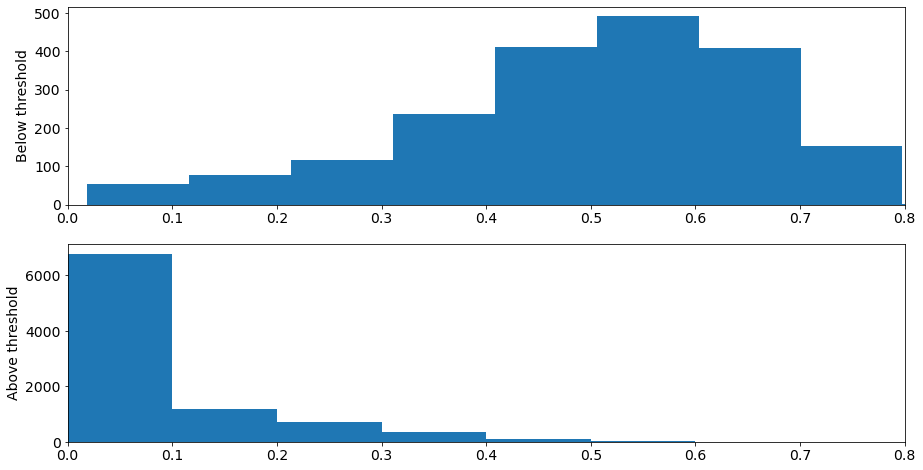

In [66]:
fig, ax = plt.subplots(2)
ax[0].hist(pscores_noaudit)
ax[0].set_xlim(0,.8)
ax[0].set_ylabel("Below threshold")
ax[1].hist(predictedP)
ax[1].set_xlim(0,.8)
ax[1].set_ylabel("Above threshold")


plt.show()

### Matching algorithm 

Now we create a simple algorithm, that, for each observation in the treatment group, finds a control firm that has the closest propensity score to each treatment group. There is a growing literature on the optimal way of designing such matching algorithms - and it is one of the places where we see a clear intersection of machine learning techniques and traditional statistical techniques. 

In [67]:
def matching(treatments, controls):
    """
    treatments: list of observed treated variables
    controls: dataframe with three columns: 
        value, cid, year
    
    Algorithm: 
        Start with first value of treatment (outer loop)
            start with first value of control (inner loop)
                and set this to match
        
    """
    matchedValues = [] #list of matched Pscores
    matchedIndex = [] #list of CID of matched Pscores
    matchValue=0
    matchIndex=0
    
    for tindex, treat in enumerate(treatments):
        for cindex, cont in enumerate(controls):
            if (treat-cont)**2<(treat-matchValue)**2:
                matchValue=cont
                matchIndex = cindex
                
        #add closest match
        matchedValues.append(matchValue)
        matchedIndex.append(matchIndex)
        #remove from controls, or do we want to allow for duplicates? 
        #controls.pop(match_index)
        
    matchedDict = {"matchedValues":matchedValues, "matchedIndex": matchedIndex}
    matchedDF = pd.DataFrame(matchedDict)

    return(matchedDF)       

In [68]:
matchedControl = matching(pscores_noaudit.tolist(), predictedP.tolist())

In [69]:
matchedControl.head()

,matchedValues,matchedIndex
0,0.463696,6463
1,0.590797,7032
2,0.626549,2234
3,0.675170,7595
4,0.333044,5125


In [70]:
mindex = matchedControl.matchedIndex.values
potentialControls = aq_rs[aq_rs.vol_auditor==0]
mcontrols = potentialControls.iloc[mindex,]

Now we check the balance of our new, synthetic, control group: 

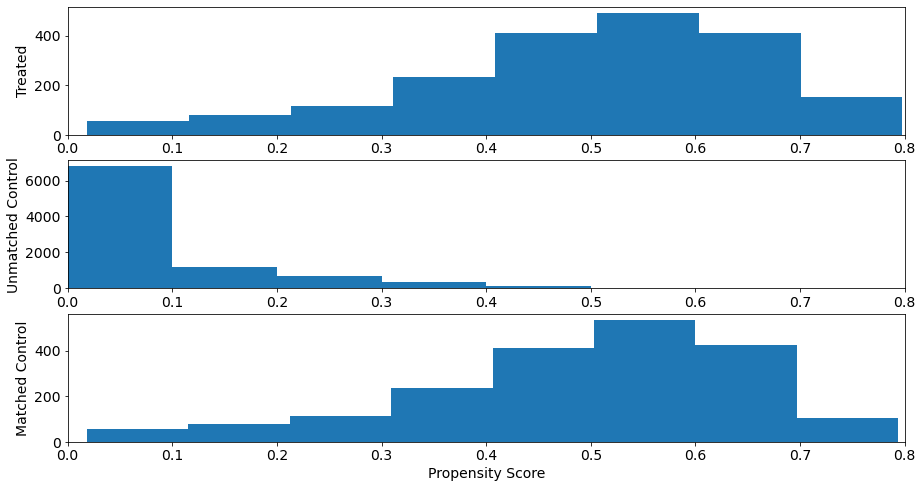

In [73]:
fig, ax = plt.subplots(3)
ax[0].hist(pscores_noaudit)
ax[0].set_xlim(0,.8)
ax[0].set_ylabel("Treated")
ax[1].hist(predictedP)
ax[1].set_xlim(0,.8)
ax[1].set_ylabel("Unmatched Control")
ax[2].hist(matchedControl.matchedValues)
ax[2].set_xlim(0,.8)
ax[2].set_ylabel("Matched Control")
ax[2].set_xlabel("Propensity Score")
plt.show()

It looks much better!

We now run a regression with our matched control group

In [74]:
matched_results = []

#treatments are those that were eligible for voluntary auditing, but did not choose to be audited
treatments = aq_rs[((aq_rs.vol_auditor==1) & (aq_rs.choseAudit==0))]

matched_sample =pd.concat([mcontrols, treatments], axis=0)

matched_sample["treated"] = 1*(matched_sample.vol_auditor==1)

matched_mod1 = smf.ols("utbytte~treated + C(year)", 
                       data=matched_sample).fit(cov_type='HC3')
matched_results.append(matched_mod1)
matched_mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     6.199
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           9.86e-06
Time:                        13:07:56   Log-Likelihood:                -2026.9
No. Observations:                3902   AIC:                             4066.
Df Residuals:                    3896   BIC:                             4104.
Df Model:                           5                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3005      0.030    -10.179      0.000      -0.358      -0.243
C(year)[T.2012]    -0.0038      0.029     -0.131      0.895      -0.060       0.053
C(year)[T.2013]     0.0439      0.030      1.453      0.146      -0.015       0.103
C(year)[T.2014]    -0.0020      0.029     -0.068      0.946      -0.060       0.056
C(year)[T.2015]     0.0402      0.033      1.217      0.224      -0.025       0.105
treated             0.0560      0.015      3.720      0.000       0.026       0.085
==============================================================================
Omnibus:                     6771.205   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12240465.458
Skew:                          11.766   Prob(JB):                         0.00
Kurtosis:                     276.374   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Notice, that this is the same, *naive* model we started with, but this time with a matched control. We now get a positive coefficient on our *treatment* indicator, which is the same as the *no_auditor* indicator. 

If we add operating income as a controlling variable, we get results that start approaching our results for our regression discontinuity design from earlier: 

In [76]:
matched_mod1p1 = smf.ols("utbytte~treated + C(year) + driftsinntekter", 
                       data=matched_sample).fit(cov_type='HC3')
matched_results.append(matched_mod1p1)
matched_mod1p1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                utbytte   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.251
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           6.75e-09
Time:                        13:10:07   Log-Likelihood:                -2008.4
No. Observations:                3902   AIC:                             4031.
Df Residuals:                    3895   BIC:                             4075.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.3025      0.029    -10.346      0.000      -0.360      -0.245
C(year)[T.2012]    -0.0259      0.029     -0.905      0.365      -0.082       0.030
C(year)[T.2013]     0.0431      0.030      1.449      0.147      -0.015       0.101
C(year)[T.2014]     0.0072      0.029      0.248      0.805      -0.050       0.065
C(year)[T.2015]     0.0435      0.033      1.322      0.186      -0.021       0.108
treated             0.1036      0.019      5.421      0.000       0.066       0.141
driftsinntekter     0.0742      0.013      5.786      0.000       0.049       0.099
==============================================================================
Omnibus:                     6769.805   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12354519.311
Skew:                          11.756   Prob(JB):                         0.00
Kurtosis:                     277.656   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

# Exercises

## What are the effects of minimum wage laws on employment: Difference-in-Difference

Minimum wage laws have been controversial in several countries, but especially the US, where minimum wages are set at both the federal level and at higher levels by some states. A very basic economic model would suggest that if you raise the minimum wage, this would lead to less employment. And this has been one of the main arguments *against* having or raising a minimum wage. 

In the 1990's two researchers decided to test this hypothesis. New Jersey was set to increase their minimum wage. So the economists got some research assistants to start calling fast-food restaurants to enquire about how many employers they had and several other variables. They also called fast-food restaurants in neighboring Pennsylvania. Then after the implimentation of the policy, the researchers called the restaurants again. The results of this paper became well known because the results contradicted the standing economic wisdom: The researchers found that using a **difference-in-difference** methodology, that the higher minimum wage **increased** employment. 

In this exercise we will try to do a simplified replication of some of the paper results and see how and why to impliment a **difference-in-difference** methodology. 


- Here is the [Paper](https://davidcard.berkeley.edu/papers/njmin-aer.pdf)

- Here are definitions to the data we will load in below [codebook](http://jmaurit.github.io/anv_statistikk/codebook)

a. Take a regression of employment on the state indicator (STATE, 1=New Jersey) for data after the introduction of the new minimum wage law. Discuss problems with interpreting this as a causal effect. Take a regression only for New Jersey data on the policy indicator (afterImplim). Discuss problems with interpreting this causally. 

b. Now take a difference between restaurant employment before and after the implimentation of the law, then compare the mean values between New Jersey and Pennsylvania. 

c. Now do a regression with all data (before and after implimentation of the new law) and include dummies for state, whether the law was implimented and an interaction. The interaction effect can be considered our difference-in-difference (DinD) indicator. Interpret the results and discuss how this resolves some of the problems in a.) 

d. Add covariates to the the DinD regression for the chain indicator and ownership type (franchise or chain-owned). 

e. What assumptions are necessary in order to interpret the DinD estimator as causal?

To start, run the following code to load in and set up the data

In [11]:
colNames = ["CHAIN",   "CO_OWNED","STATE",  "SOUTHJ", "CENTRALJ","NORTHJ", "PA1",    "PA2",    "SHORE",   "NCALLS",  "EMPFT",   "EMPPT",   "NMGRS",   "WAGE_ST", "INCTIME", "FIRSTINC","BONUS",   "PCTAFF",  "MEALS",   "OPEN",    "HRSOPEN", "PSODA",   "PFRY",    "PENTREE", "NREGS",   "NREGS11", "TYPE2",   "STATUS2", "DATE2",   "NCALLS2", "EMPFT2",  "EMPPT2",  "NMGRS2",  "WAGE_ST2","INCTIME2","FIRSTIN2","SPECIAL2","MEALS2",  "OPEN2R",  "HRSOPEN2","PSODA2",  "PFRY2",   "PENTREE2","NREGS2",  "NREGS112"]
minWage = pd.read_table("minWage.dat", sep="\s+", names=colNames)
minWage

,CHAIN,CO_OWNED,STATE,SOUTHJ,CENTRALJ,NORTHJ,PA1,PA2,SHORE,NCALLS,...,FIRSTIN2,SPECIAL2,MEALS2,OPEN2R,HRSOPEN2,PSODA2,PFRY2,PENTREE2,NREGS2,NREGS112
46,1,0,0,0,0,0,1,0,0,0,...,0.08,1,2,6.50,16.50,1.03,.,0.94,4,4
49,2,0,0,0,0,0,1,0,0,0,...,0.05,0,2,10.00,13.00,1.01,0.89,2.35,4,4
506,2,1,0,0,0,0,1,0,0,0,...,0.25,.,1,11.00,11.00,0.95,0.74,2.33,4,3
56,4,1,0,0,0,0,1,0,0,0,...,0.15,0,2,10.00,12.00,0.92,0.79,0.87,2,2
61,4,1,0,0,0,0,1,0,0,0,...,0.15,0,2,10.00,12.00,1.01,0.84,0.95,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2,1,1,0,0,1,0,0,0,3,...,0.50,0,1,11.00,11.00,1.05,0.84,2.32,3,2
424,2,1,1,0,0,1,0,0,0,0,...,0.50,0,1,11.00,14.00,1.05,0.94,2.32,5,3
426,3,1,1,0,0,1,0,0,0,0,...,0.25,1,2,6.00,18.00,1.11,1.05,1.05,6,5
427,4,0,1,0,0,1,0,0,0,3,...,.,1,2,10.50,12.50,1.11,1.09,2.07,2,2


In [12]:
#Split the data into two data sets: before and after
minWage1 = minWage.loc[:, ['CHAIN', 'CO_OWNED', 'STATE', 'SOUTHJ', 'CENTRALJ', 'NORTHJ', 'PA1',
       'PA2', 'SHORE', 'NCALLS', 'EMPFT', 'EMPPT', 'NMGRS', 'WAGE_ST',
       'INCTIME', 'FIRSTINC', 'BONUS', 'PCTAFF', 'MEALS', 'OPEN', 'HRSOPEN',
       'PSODA', 'PFRY', 'PENTREE', 'NREGS', 'NREGS11']]


minWage2 = minWage.loc[:, ['CHAIN', 'CO_OWNED', 'STATE', 'SOUTHJ', 'CENTRALJ', 'NORTHJ', 'PA1',
       'PA2', 'SHORE','NCALLS2', 'EMPFT2', 'EMPPT2', 'NMGRS2', 'WAGE_ST2',
       'INCTIME2', 'FIRSTIN2', 'BONUS', 'PCTAFF', 'MEALS2', 'OPEN2R', 'HRSOPEN2',
       'PSODA2', 'PFRY2', 'PENTREE2', 'NREGS2', 'NREGS112']]

In [13]:
#indicator variable for before or after implimentation
minWage1["afterImplim"] = 0
minWage2["afterImplim"] = 1

#rename columns so consistent with minWage1
minWage2.columns = ['CHAIN', 'CO_OWNED', 'STATE', 'SOUTHJ', 'CENTRALJ', 'NORTHJ', 'PA1',
       'PA2', 'SHORE', 'NCALLS', 'EMPFT', 'EMPPT', 'NMGRS', 'WAGE_ST',
       'INCTIME', 'FIRSTINC','BONUS', 'PCTAFF', 'MEALS', 'OPEN', 'HRSOPEN',
       'PSODA', 'PFRY', 'PENTREE', 'NREGS', 'NREGS11', 'afterImplim']

In [15]:
minWage_long = pd.concat([minWage1, minWage2])
minWage_long

,CHAIN,CO_OWNED,STATE,SOUTHJ,CENTRALJ,NORTHJ,PA1,PA2,SHORE,NCALLS,...,PCTAFF,MEALS,OPEN,HRSOPEN,PSODA,PFRY,PENTREE,NREGS,NREGS11,afterImplim
46,1,0,0,0,0,0,1,0,0,0,...,.,2,6.5,16.5,1.03,1.03,0.52,3,3,0
49,2,0,0,0,0,0,1,0,0,0,...,.,2,10.0,13.0,1.01,0.90,2.35,4,3,0
506,2,1,0,0,0,0,1,0,0,0,...,30.0,2,11.0,10.0,0.95,0.74,2.33,3,3,0
56,4,1,0,0,0,0,1,0,0,0,...,0.0,2,10.0,12.0,0.87,0.82,1.79,2,2,0
61,4,1,0,0,0,0,1,0,0,0,...,0.0,3,10.0,12.0,0.87,0.77,1.65,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2,1,1,0,0,1,0,0,0,1,...,33.0,1,11.00,11.00,1.05,0.84,2.32,3,2,1
424,2,1,1,0,0,1,0,0,0,1,...,45.0,1,11.00,14.00,1.05,0.94,2.32,5,3,1
426,3,1,1,0,0,1,0,0,0,.,...,75.0,2,6.00,18.00,1.11,1.05,1.05,6,5,1
427,4,0,1,0,0,1,0,0,0,4,...,40.0,2,10.50,12.50,1.11,1.09,2.07,2,2,1


In [16]:
#convert some series from character/text to numeric
minWage_long["EMPFT"] = pd.to_numeric(minWage_long.EMPFT, errors='coerce')
minWage_long["EMPPT"] = pd.to_numeric(minWage_long.EMPPT, errors='coerce')
minWage_long["NMGRS"] = pd.to_numeric(minWage_long.NMGRS , errors='coerce')
minWage_long["WAGE_ST"] = pd.to_numeric(minWage_long.WAGE_ST, errors='coerce')
minWage_long["INCTIME"] = pd.to_numeric(minWage_long.INCTIME, errors='coerce')



In [17]:
#Part-time employee is counted as 50% of a full-time employee
minWage_long["EMP"] = minWage_long["EMPFT"] + .5*minWage_long["EMPPT"] 

## 2. Instrumental variables: simulating (optional)

(Based on ROS Exercise 21.2 and 21.3, p.450-451)



Consider a hypothetical randomized encouragement design. In particular, imagine a study in which 1000 students entering any undergraduate degree program in Business in a major university are randomly assigned to one of two conditions. 

One group is encouraged via an email from the chair of their department to participate in a one-week math boot camp just before the start of their first semester. Students in the other group are also allowed to participate but receive no special encouragement. These students would have had to discover on their own the existence of the program on the university website.

The running variable is test score on the final exam for a required math course, and the outcome variable 𝑦 that you will simulate below represents the difference between that score and the threshold for passing. Thus a negative value for a student reflects the fact that the student would not be eligible for that course. Below we will generate data for a sample of 1000 individuals.

(a) We will simulate compliance status. We assume that 25% of individuals are compliers who will take the math bootcamp if they receive an email, but otherwise will not. 60% are never-takers who will never take the math bootcamp no matter if they receive the email and 15% are always-takers, who will always take the bootcamp. 

We generate 𝑑0 and 𝑑1 vectors to reflect this. We also generate a vector indicating compliance type, 𝑐.


(b) We simulate the potential outcomes in a way that meets the following criteria: 

- The average effect of 𝑧 on 𝑦 for the compliers is 4.

- The average 𝑦(𝑧 = 0) for never-takers is 0; the average 𝑦(𝑧 = 0) for compliers is 3;  - The average 𝑦(𝑧 = 0) for always-takers is 6.

- The residual standard deviation is 1 for everyone in the sample (generated independently for each potential outcome).

(c) We put 𝑇0, 𝑇1, 𝑦0, 𝑦1 into one dataset called IV_df. You can also include a variable, 𝑐, indicating compliance group if you created one. We then also create the observed variables, y (actual test scores), T (whether a student went to the math boot camp) and z (whether they were randomly picked to receive an email encouragement).

In [5]:
#a.)
#compliance 
# 0 complier, 1 never takers, 2 always takers
c = np.array(np.concatenate([["Complier"]*250, ["Never Taker"]*600, ["Always Taker"]*150]))
d0 = np.array(np.concatenate([[0]*850, [1]*150])) #dummy for always takers
d1 = np.array(np.concatenate([[1]*250, [0]*750])) #dummy for complier



In [6]:
#z is the encouragement
z=np.array(np.concatenate([np.zeros(500), np.ones(500)]))
#now let us randomize z
np.random.shuffle(z)

In [7]:
#Potential attendance outcomes

# Would attend if not encouraged
T_i0 = d0

# Would attend if encouraged
T_i1 = d0+d1



In [8]:
#Potential test outcomes

#test score given that they were encouraged to take test. 

y0_complier = np.random.normal(3,1,250)
y0_neverTaker = np.random.normal(0,1,600) # y(z=0)
y0_alwaysTaker = np.random.normal(6,1,150)


y0 = np.concatenate([y0_complier, y0_neverTaker, y0_alwaysTaker])

complierEffect = np.random.normal(4,1,1000)

#out come

y1 = y0 + d1*complierEffect

In [11]:
IV_df = pd.DataFrame({
    "complierStatus":c, 
    "z":z,
    "d0":d0,
    "d1":d1,
    "T0":T_i0,
    "T1":T_i1,
    "y0": y0,
    "y1": y1, 
    "encourEffect": y1-y0
})
IV_df

,complierStatus,z,d0,d1,T0,T1,y0,y1,encourEffect
0,Complier,0.0,0,1,0,1,0.568668,4.387267,3.818599
1,Complier,1.0,0,1,0,1,1.327189,5.027651,3.700463
2,Complier,1.0,0,1,0,1,2.846374,7.192827,4.346453
3,Complier,1.0,0,1,0,1,3.547111,8.005861,4.458751
4,Complier,1.0,0,1,0,1,2.333885,3.735922,1.402037
...,...,...,...,...,...,...,...,...,...
995,Always Taker,1.0,1,0,1,1,5.144561,5.144561,0.000000
996,Always Taker,0.0,1,0,1,1,7.603954,7.603954,0.000000
997,Always Taker,0.0,1,0,1,1,4.933091,4.933091,0.000000
998,Always Taker,0.0,1,0,1,1,5.806916,5.806916,0.000000


In [12]:
IV_df.groupby("complierStatus")["encourEffect"].aggregate(np.mean)

complierStatus
Always Taker    0.000000
Complier        4.062673
Never Taker     0.000000
Name: encourEffect, dtype: float64

In [13]:
#actual attendance outcome
IV_df["T"] = d1*z + d0

In [14]:
#observed outcome
IV_df["y"] = y0*(1-z) + y1*(z)

Now that we have created our data set let's consider the perspective of the analyst. They clearly do not get to see the counterfactuals (y0, y1, T0,T1), they only get to see whether a student attended (T), the score on the test (y) and whether they were randomly part of the group that was encouraged (z).

a.) Start with a naive regression of T on y ($y_i = \alpha + beta T_i + \epsilon$). What are the results. Are the results biased? explain

b.) Use 2-stage least squares/Instrumental variables to estimate the effect of T on Y

(You might want to see the [two stage least squares estimation tool](https://www.statsmodels.org/dev/generated/statsmodels.sandbox.regression.gmm.IV2SLS.html) in statsmodels)

c.) Discuss why instrumental variables worked in this case / the assumptions necessary for IV to work. 

## 3 Free problem. 

Consider a regression you have run in a previous lab. 

- Discuss the extent to which you can consider the results causal. 

- Can you apply any of the methods discussed in the lab or in ROS in order to better approximate a causal result. 

- If possible, apply methods in order to get closer to a causal effect (For example: including extra covariates, fixed effects, matching, regression discontinuity, instrumental variables). If not possible discuss why not. 